# Preparation:

## Hyper-parameters.


---

Users: *please **edit the first cell only** and leave others untouched, unless you have read through the script thoroughly.*

---



In [ ]:
import os
import sys
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates
import datetime
import time
from functools import reduce

######################################
########### User Settings ############
######################################

epochs = 5000
batch_size = 128
initial_lr=0.001 # learning rate

train_ratio = 0.7 # ratio of training set, default = 0.7

# choose chronological training set split method amond ['manual', 'first', 'last', 'first_n_last']
which_70pct = 'first'

'''
Other hyperparameters related to input pre-processing
'''
# Downsampling ratio of Outflow
downsample_outflow = 1 # positive integer, default = 1

# Number of daily values used in inputs
number_of_daily_inputs = 8 # positive integer,default = 8

# Number of averaging windows in input pre-processing,
number_of_windows= 10 # positive integer, default = 10

# Length of averaging windows in input pre-processing
averaging_window_len = 11 # positive integer, default = 11


'''
NN models. Seven architectures available:
MLP; LSTM; GRU; ResNet; Res-LSTM; Res-GRU
Select by uncommenting
'''
## 1. To train an MLP Network: (uncomment both 2 lines below):
model_str_def = 'd8_d2_o1'
input_prepro_option=1

## 2. To train an LSTM Network (uncomment both 2 lines below):
# model_str_def = 'lstm1_f_o1'
# input_prepro_option = 2


## 3. To train a GRU Network (uncomment both 2 lines below):
# model_str_def = 'g1_f_o1'
# input_prepro_option = 2

## 4. To train a ResNet (uncomment both 2 lines below):
# model_str_def = 'resnet_16_8'
# num_res_blocks=1
# num_neurons_multiplier = [int(x) for x in model_str_def.split('_')[1:]]
# input_prepro_option = 2

## 5/6. To train a Res-LSTM or Res-GRU (uncomment both 3 lines below):
# model_str_def = 'residual_lstm_8_2' # choose between ['residual_lstm_8_2', 'residual_gru_8_2']
# num_neurons_multiplier=[int(x) for x in model_str_def.split('_')[2:]]
# input_prepro_option = 2

## 7. To train a Transformer (uncomment both 2 lines below):
# model_str_def = 'transformer'
# input_prepro_option = 2


######################################
######## End of User Settings ########
######################################

"""
Define save name suffix based on user settings.

This suffix will be appended to the names of
model (h5, dump), results (pickle) and images (png)
"""
savepath_suffix = ''
if downsample_outflow > 1:
    savepath_suffix += '_ds_1over%d' % (downsample_outflow)
if any([number_of_daily_inputs != 8,number_of_windows!=10, averaging_window_len != 11]):
    savepath_suffix += '_%dx%d_and_%dday' % (window_size,nwindows,ndays)


"""
Check types and values of hyperparameters
"""
hyperparameter_list = [downsample_outflow, number_of_daily_inputs, number_of_windows,averaging_window_len]
assert all(isinstance(i, int) for i in hyperparameter_list), 'Downsampling ratio, number of daily values and windows, length of windows must be integers.'
assert all(i>=0 for i in hyperparameter_list), 'Downsampling ratio, number of daily values and windows, length of windows must be non-negative.'

# Whether to:
# train a model from scratch (= True) or
# skip training, load trained models (= False)
train_models = True

In [ ]:
google_drive_dir = 'X2_Estimation'
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
gdrive_root_path = os.path.join('/content/drive','MyDrive',google_drive_dir)

sys.path.append(gdrive_root_path)
import annutils

data_file = "dcp_naa_2040_slr15cm_traing_inp.xlsx"
exclude_stations = ['unnamed: 1'] # date column
select_seasons = None
picked_training_years = None
interval = '1D'

resume_training = False
num_sheets = 4

if input_prepro_option ==1:
    # option 1: apply pre-defined average windowing:
    ndays=number_of_daily_inputs
    window_size=averaging_window_len
    nwindows=number_of_windows
elif input_prepro_option ==2:
    # option 2: directly use daily measurements as inputs
    ndays=number_of_daily_inputs + number_of_windows * averaging_window_len
    window_size=0
    nwindows=0
else:
    raise "input_prepro_option=%d is not supported, please select between {0, 1}" % input_prepro_option

# percentile thresholds for ranged results
percentiles = [0,0.75,0.95]

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
# !pip install -q -U keras-tuner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import layers
#import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score


## Read data

In [ ]:
dflist = [pd.read_excel(os.path.join(gdrive_root_path,data_file),i,index_col=0,parse_dates=True) for i in range(num_sheets)]

# Map columns to their variables names
rename_columns = {"Unnamed: 1": "Date", "DELTA": "X2",
                          'CALSIM-SMOOTH':'Outflow','DWR':'Tide',
                          'CALSIM':'SMSC Gate'}

In [ ]:
dfouts=dflist[-1]

output_stations_w_duplicates_for_time = dfouts.columns[~dfouts.columns.str.contains('_dup')]
output_stations = list(set(output_stations_w_duplicates_for_time))
print('Found %d columns in X2 sheet: ' % len(output_stations),end='')
print(output_stations)

stations_to_exclude = []
for s in output_stations:
    if s.lower() in exclude_stations:
        if len(stations_to_exclude)==0:
            print('Excluded column(s): ', end='')
        stations_to_exclude.append(s)
        print(s, end=', ')
        dfouts = dfouts.drop(s,axis=1)
for s in stations_to_exclude:
    output_stations.remove(s)

Found 2 columns in X2 sheet: ['DELTA', 'Unnamed: 1']
Excluded column(s): Unnamed: 1, 

In [ ]:
# Align input and output data
df_inpout = reduce(lambda left,right: pd.merge(left,right,on='Unnamed: 1',how='outer'), dflist[1:num_sheets])
# Remove days with missing data
df_inpout = df_inpout[~df_inpout['Unnamed: 1'].isnull()].fillna(method='ffill').dropna(axis=0)
# Change name of index column
df_inpout = df_inpout.rename(columns={'Unnamed: 1':'Date'}).set_index('Date')
# Split dataframe into inputs and output
dfinps = df_inpout.loc[:,~df_inpout.columns.isin(dflist[num_sheets-1].columns)].rename(columns=rename_columns)
# dfinps = dfinps.drop(labels=exclude_input_var, axis=1)
# dfinps = dfinps[[include_input_var]]
# dfinps_idx = dfinps.reset_index().index
# dfinps.loc[dfinps_idx % downsample_outflow != 0,'Outflow']=np.nan
# print(dfinps)
# dfinps.interpolate(inplace=True)

dfouts = df_inpout.loc[:,output_stations].rename(columns=rename_columns)

In [ ]:
dfinps

,Outflow,Tide,SMSC Gate
Date,,,
1922-10-31,8737.846114,4.4265,1.0
1922-11-01,8973.129989,4.6395,1.0
1922-11-02,9038.274692,5.1778,1.0
1922-11-03,9065.592794,5.4950,1.0
1922-11-04,9080.096695,5.8458,1.0
...,...,...,...
2016-09-26,3000.000000,5.5320,0.0
2016-09-27,3000.000000,5.4730,0.0
2016-09-28,3000.000000,5.3448,0.0


In [ ]:
dfouts

,X2
Date,
1922-10-31,78.729720
1922-11-01,78.692067
1922-11-02,79.028608
1922-11-03,79.588173
1922-11-04,80.268319
...,...
2016-09-26,44.322151
2016-09-27,44.322151
2016-09-28,44.322151


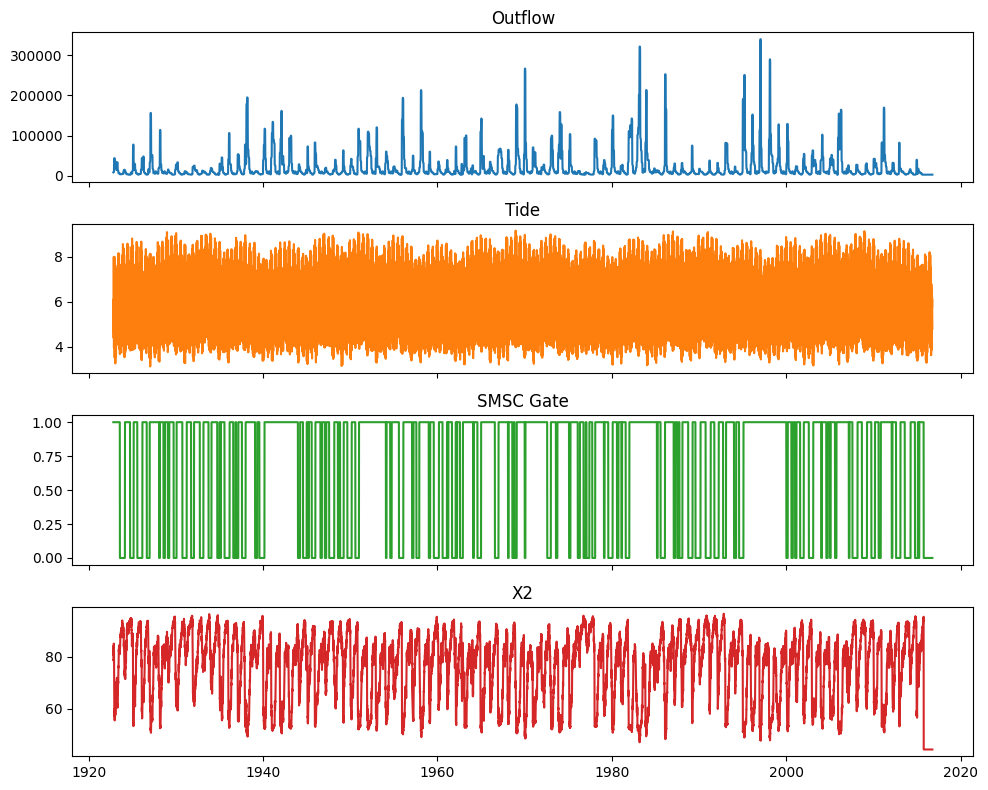

In [ ]:
# Visualize data
df_inpout = df_inpout.rename(columns=rename_columns)
fig, ax = plt.subplots(4,1,sharex=True,figsize=(10,8))
for i,y in enumerate(['Outflow','Tide','SMSC Gate','X2']):
    ax[i].plot(df_inpout.index,df_inpout[y],color='C%d'%i)
    ax[i].title.set_text(y)
fig.tight_layout()

## Training and Test Periods
Chronologically split the data: Training is from 1922 - 1987 and Validation from 1988 - 2016

In [ ]:
start_year = max(dfinps.index[0].year, dfouts.index[0].year)
end_year = min(dfinps.index[-1].year, dfouts.index[-1].year)
if which_70pct =='first':
    calib_slice = slice(str(start_year), str(int(start_year+train_ratio*(end_year-start_year))))
    valid_slice = slice(str(int(start_year+train_ratio*(end_year-start_year))+1), str(end_year))
elif which_70pct =='last':
    calib_slice = slice(str(int(start_year+(1-train_ratio)*(end_year-start_year))+1), str(end_year))
    valid_slice = slice(str(start_year), str(int(start_year+(1-train_ratio)*(end_year-start_year))))
elif which_70pct =='first_n_last':
    calib_slice = [slice(str(start_year),
                            str(int(start_year+train_ratio/2*(end_year-start_year)))),
                    slice(str(int(start_year+(1-train_ratio/2)*(end_year-start_year))+1),
                            str(end_year))]
    valid_slice = slice(str(int(start_year+train_ratio/2*(end_year-start_year))+1),
                        str(int(start_year+(1-train_ratio/2)*(end_year-start_year))))
elif which_70pct =='manual' and picked_training_years is not None:
    calib_slice = [slice(str(start_year), str(end_year)) for (start_year,end_year) in picked_training_years]
    valid_slice = [slice(start_year, end_year) for ((_,start_year),(end_year,_)) in zip([(None,'1989-10-1'),]+picked_training_years,picked_training_years+[('2020-9-30',None),])]
else:
    raise Exception('Unknown data splitting method')
print('Training set:', calib_slice)
print('Test set:', valid_slice)

Training set: slice('1922', '1987', None)
Test set: slice('1988', '2016', None)


## ResNet Block Building Function

In [ ]:
parameters = {
    "kernel_initializer": "he_normal"
}

def basic_1d(
    filters,
    stage=0,
    block=0,
    kernel_size=3,
    numerical_name=False,
    stride=None,
    force_identity_shortcut=False
):
    """
    A one-dimensional basic block.
    :param filters: the output’s feature space
    :param stage: int representing the stage of this block (starting from 0)
    :param block: int representing this block (starting from 0)
    :param kernel_size: size of the kernel
    :param numerical_name: if true, uses numbers to represent blocks instead of chars (ResNet{101, 152, 200})
    :param stride: int representing the stride used in the shortcut and the first conv layer, default derives stride from block id
    """
    if stride is None:
        if block != 0 or stage == 0:
            stride = 1
        else:
            stride = 2

    # axis = -1 if keras.backend.image_data_format() == "channels_last" else 1


    if block > 0 and numerical_name:
        block_char = "b{}".format(block)
    else:
        block_char = chr(ord('a') + block)

    stage_char = str(stage + 2)

    def f(x):
        y = keras.layers.ZeroPadding1D(padding=1,name="padding{}{}_branch2a".format(stage_char, block_char))(x)
        y = keras.layers.Conv1D(filters,kernel_size,strides=stride,use_bias=False,
                                name="res{}{}_branch2a".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu", name="res{}{}_branch2a_relu".format(stage_char, block_char))(y)

        y = keras.layers.ZeroPadding1D(padding=1,name="padding{}{}_branch2b".format(stage_char, block_char))(y)
        y = keras.layers.Conv1D(filters,kernel_size,use_bias=False,
                                name="res{}{}_branch2b".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)

        if block != 0 or force_identity_shortcut:
            shortcut = x
        else:
            shortcut = keras.layers.Conv1D(filters,1,strides=stride,use_bias=False,
                                           name="res{}{}_branch1".format(stage_char, block_char),
                                           **parameters)(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)

        y = keras.layers.Add(name="res{}{}".format(stage_char, block_char))([y, shortcut])

        y = keras.layers.Activation("relu",name="res{}{}_relu".format(stage_char, block_char))(y)

        return y

    return f


def bottleneck_1d(
    filters,
    stage=0,
    block=0,
    kernel_size=3,
    numerical_name=False,
    stride=None,
):
    """
    A one-dimensional bottleneck block.
    :param filters: the output’s feature space
    :param stage: int representing the stage of this block (starting from 0)
    :param block: int representing this block (starting from 0)
    :param kernel_size: size of the kernel
    :param numerical_name: if true, uses numbers to represent blocks instead of chars (ResNet{101, 152, 200})
    :param stride: int representing the stride used in the shortcut and the first conv layer, default derives stride from block id
    """
    if stride is None:
        stride = 1 if block != 0 or stage == 0 else 2

    # axis = -1 if keras.backend.image_data_format() == "channels_last" else 1


    if block > 0 and numerical_name:
        block_char = "b{}".format(block)
    else:
        block_char = chr(ord('a') + block)

    stage_char = str(stage + 2)

    def f(x):
        y = keras.layers.Conv1D(filters,1,strides=stride,use_bias=False,
                                name="res{}{}_branch2a".format(stage_char, block_char),
                                **parameters)(x)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu",name="res{}{}_branch2a_relu".format(stage_char, block_char))(y)

        y = keras.layers.ZeroPadding1D(padding=1,name="padding{}{}_branch2b".format(stage_char, block_char))(y)
        y = keras.layers.Conv1D(filters,kernel_size,use_bias=False,
                                name="res{}{}_branch2b".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu",name="res{}{}_branch2b_relu".format(stage_char, block_char))(y)

        y = keras.layers.Conv1D(filters * 4, 1, use_bias=False,
                                name="res{}{}_branch2c".format(stage_char, block_char),
                                **parameters)(y)
        y = keras.layers.BatchNormalization()(y)

        if block == 0:
            shortcut = keras.layers.Conv1D(filters * 4, 1, strides=stride, use_bias=False,
                                           name="res{}{}_branch1".format(stage_char, block_char),
                                           **parameters)(x)
            shortcut = keras.layers.BatchNormalization()(shortcut)
        else:
            shortcut = x

        y = keras.layers.Add(name="res{}{}".format(stage_char, block_char))([y, shortcut])
        y = keras.layers.Activation("relu",name="res{}{}_relu".format(stage_char, block_char))(y)

        return y

    return f

## Main Model building functions

In [ ]:
"""# Custom loss function"""
def mse_loss_masked(y_true, y_pred):
    squared_diff = tf.reduce_sum(tf.math.squared_difference(y_pred[y_true>0],y_true[y_true>0]))
    return squared_diff/(tf.reduce_sum(tf.cast(y_true>0, tf.float32))+0.01)

# Define Sequential model
NFEATURES = dfinps.shape[1] # * (ndays + nwindows)
def build_layer_from_string_def(s='i120',width_multiplier=1,
                                block=0,
                                force_identity_shortcut=False,
                                return_sequences_rnn=True):
    if s[0:4] == 'lstm':
        return layers.LSTM(units = int(s[4:])*width_multiplier, return_sequences=return_sequences_rnn, activation='sigmoid')
    elif s[0:3] == 'res':
        fields = s[3:].split('x')
        return basic_1d(filters=int(fields[0]),
                        stage=int(fields[3]),
                        block=block,
                        kernel_size=int(fields[1]),
                        stride=int(fields[2]),
                        force_identity_shortcut=force_identity_shortcut)
    elif s[0:3] == 'c1d':
        fields = s[3:].split('x')
        return keras.layers.Conv1D(filters=int(fields[0]), kernel_size=int(fields[1]), strides=int(fields[2]),
                                   padding='causal', activation='linear')
    elif s[0:2] == 'td':
        return keras.layers.TimeDistributed(keras.layers.Dense(int(s[2:]), activation='elu'))
    elif s[0:2] == 'dr':
        return keras.layers.Dropout(float(s[2:]))
    # elif s[0] == 'i':
    #     return keras.layers.InputLayer(input_shape=[int(s[1:]), NFEATURES])
    elif s[0] == 'f':
        return keras.layers.Flatten()
    elif s[0] == 'g':
        return keras.layers.GRU(int(s[1:])*width_multiplier, return_sequences=return_sequences_rnn, activation='relu')
    elif s[0] == 'd':
        return keras.layers.Dense(int(s[1:])*width_multiplier, activation='elu')
    elif s[0] == 'o':
        return keras.layers.Dense(int(s[1:])*width_multiplier, activation='linear')
    else:
        raise Exception('Unknown layer def: %s' % s)

In [ ]:
def build_model_from_string_def(strdef='i120_f_d4_d2_d1',width_multiplier=1):
    layer_strings = strdef.split('_')
    inputs = keras.layers.Input(shape=[int(layer_strings[0][1:]) * NFEATURES])
    x = None
    prev_conv_output_num_of_channels = None
    return_sequences_rnn = None
    for block,f in enumerate(layer_strings[1:-1]):
        if x is None:
            if f.startswith(('lstm','g')):
                # these layers require 2D inputs and permutation
                x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
                prev_conv_output_num_of_channels = NFEATURES
                x = layers.Permute((2,1))(x)
                # return_sequences_rnn = layer_strings[block+2].startswith(('lstm','g','res','c1d'))
                return_sequences_rnn = True
            elif f.startswith(('res','c1d')):
                # these layers require 2D inputs
                x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
                prev_conv_output_num_of_channels = NFEATURES
            else:
                x = inputs


        x = build_layer_from_string_def(f,width_multiplier,block,
                                        force_identity_shortcut=(f.startswith('res') and prev_conv_output_num_of_channels==int(f[3:].split('x')[0])),
                                        return_sequences_rnn=return_sequences_rnn)(x)
        if f.startswith('lstm'):
            prev_conv_output_num_of_channels=int(f[4:])
        elif f.startswith('res') or f.startswith('c1d'):
            prev_conv_output_num_of_channels=int(f[3:].split('x')[0])


    outputs = keras.layers.Dense(int(layer_strings[-1][1:])*width_multiplier, activation='linear')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

def build_resnet_model(nhidden1=8, nhidden2=2, output_shape=1, act_func='sigmoid',
                       filters=num_sheets-1, kernel_size=3, stride=1,
                       num_res_blocks=1):
    inputs = layers.Input(shape=NFEATURES* (ndays + nwindows))
    x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
    for ii in range(num_res_blocks - 1):
        # TODO: think about conv filter numbers and kernel sizes
        intermediate_features = layers.ZeroPadding1D(padding=1,name="padding%d_branch2a" %ii)(x)
        intermediate_features = layers.Conv1D(filters=NFEATURES,kernel_size=2,strides=1,use_bias=False,
                          name="res%d_branch2a" %ii)(intermediate_features)
        intermediate_features = layers.BatchNormalization()(intermediate_features)
        intermediate_features = layers.Activation("relu", name="res%d_branch2a_relu" % ii)(intermediate_features)

        intermediate_features = layers.Conv1D(filters=NFEATURES,kernel_size=2,strides=1,use_bias=False,
                          name="res%d_branch2b" %ii)(intermediate_features)
        intermediate_features = layers.BatchNormalization()(intermediate_features)
        intermediate_features = layers.Activation("relu", name="res%d_branch2b_relu" % ii)(intermediate_features)

        shortcut = x
        x = layers.Add(name="res%d_add" % ii)([intermediate_features, shortcut])

    y = layers.ZeroPadding1D(padding=1,name="padding%d_branch2a" % num_res_blocks)(x)
    y = layers.Conv1D(filters,kernel_size,strides=stride,use_bias=False,
                                name="res%d_branch2a" % num_res_blocks)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation("relu", name="res%d_branch2a_relu" % num_res_blocks)(y)

    y = layers.ZeroPadding1D(padding=1,name="padding%d_branch2b" % num_res_blocks)(y)
    y = layers.Conv1D(filters,kernel_size,use_bias=False,
                            name="res%d_branch2b" % num_res_blocks)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Flatten()(y)
    y = layers.Dense(nhidden1, activation=act_func)(y)

    shortcut = inputs
    shortcut = layers.Dense(nhidden1, activation=act_func)(shortcut)

    y = layers.Add(name="res%d_add" % num_res_blocks)([y, shortcut])

    y = layers.Activation("relu",name="res_relu")(y)


    y = layers.Dense(nhidden2, activation=act_func)(y)
    outputs= layers.Dense(output_shape, activation=keras.activations.linear,name='output')(y)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

def build_residual_lstm_model(nhidden1=8, nhidden2=2, output_shape=1, act_func='sigmoid',layer_type='lstm',conv_init=None):
    rnn_layer = layers.LSTM if layer_type == 'lstm' else layers.GRU
    inputs = layers.Input(shape=NFEATURES*(ndays+nwindows))
    x = layers.Reshape((ndays+nwindows,num_sheets-1))(inputs)
    x = layers.Permute((2,1))(x)

    y = tf.keras.layers.Conv1D(8+10,1, activation='relu',
                            kernel_initializer=conv_init,
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0, l2=0),
                            trainable=False)(x)

    y = layers.Flatten()(y)
    y = layers.Dense(nhidden1, activation=act_func)(y)
    y = layers.Dense(nhidden2, activation=act_func)(y)
    y = layers.Dense(output_shape, activation=keras.activations.linear,name='mlp_output')(y)


    shortcut = layers.Dense(nhidden1, activation=act_func)(x)
    shortcut = rnn_layer(units = output_shape*2, activation=act_func,return_sequences=True)(shortcut)
    shortcut = layers.Flatten()(shortcut)
    shortcut = layers.Dense(output_shape, activation=keras.activations.linear,name='lstm_output')(shortcut)

    outputs = layers.Add(name="res_add")([y, shortcut])
    # outputs = layers.Activation("relu",name="res_relu")(outputs)
    outputs = layers.LeakyReLU(alpha=0.3,name="res_relu")(outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer(head_size,
                      num_heads,
                      ff_dim,
                      num_transformer_blocks,
                      mlp_units,
                      output_shape,
                      dropout=0,
                      mlp_dropout=0):
    inputs = keras.Input(shape=NFEATURES*(ndays+nwindows))
    x = layers.Reshape((ndays+nwindows,NFEATURES))(inputs)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(output_shape)(x)
    outputs = layers.LeakyReLU(alpha=0.3,name="res_relu")(outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=initial_lr), loss=mse_loss_masked)
    return model

Re-order stations

# Train Models

In [ ]:
full_model_str_def = 'i%d_'%(ndays + nwindows) +model_str_def
if train_models:
    # prepare dataset
    model_path_prefix = "X2_%s_%s%s" % (full_model_str_def, which_70pct+'_chronological'+('' if select_seasons is None else ('_' + select_seasons)),savepath_suffix)


    (xallc, yallc), (xallv, yallv), xscaler, yscaler = \
    annutils.create_training_sets([dfinps],
                                [dfouts],
                                calib_slice=calib_slice,
                                valid_slice=valid_slice,
                                ndays=ndays,window_size=window_size,nwindows=nwindows,
                                keep_months_only=select_seasons)

    if model_str_def.startswith('resnet'):
        model = build_resnet_model(nhidden1=num_neurons_multiplier[0]*yallc.shape[1], nhidden2=num_neurons_multiplier[1]*yallc.shape[1], output_shape=yallc.shape[1],
                                    num_res_blocks=num_res_blocks)
    elif model_str_def.startswith('residual_lstm') or model_str_def.startswith('residual_gru'):
        conv_init = tf.constant_initializer(annutils.conv_filter_generator(ndays=8,window_size=11,nwindows=10))

        model = build_residual_lstm_model(num_neurons_multiplier[0]*len(output_stations),
                                num_neurons_multiplier[1]*len(output_stations),
                                output_shape=yallc.shape[1],
                                act_func='sigmoid',
                                layer_type=model_str_def.lower().split('_')[1],
                                conv_init=conv_init)
    elif model_str_def == 'transformer':
        model = build_transformer(head_size=256,
                                num_heads=4,
                                ff_dim=4,
                                num_transformer_blocks=4,
                                mlp_units=[128],
                                output_shape=yallc.shape[1],
                                mlp_dropout=0.4,
                                dropout=0.25)
    else:
        model = build_model_from_string_def(full_model_str_def,width_multiplier=yallc.shape[1])


    display(model.summary())
    start_time = time.time()
    history = model.fit(
        xallc,
        yallc,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(xallv, yallv),
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=100, mode="min", restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=50, min_lr=1e-6, verbose=1),
        ],
        verbose=0
    )
    print('Finished training %d epochs in %.2f seconds' % (history.epoch[-1], time.time() - start_time))
    # pd.DataFrame(history.history).hvplot(logy=True) # if you want to view the graph for calibration/validation training
    annutils.save_model(os.path.join(gdrive_root_path, 'models', model_path_prefix) , model, xscaler, yscaler)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 54)]              0         
                                                                 
 dense (Dense)               (None, 8)                 440       
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


None


Epoch 139: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 195: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 245: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.

Epoch 295: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.

Epoch 345: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.

Epoch 395: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.

Epoch 445: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.

Epoch 495: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.

Epoch 545: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.

Epoch 595: ReduceLROnPlateau reducing learning rate to 0.00010737419361248613.
Finished training 618 epochs in 258.57 seconds


# Evaluate Models

## Define evaluation metrics

In [ ]:
from collections import defaultdict
eval_metrics = ['MSE', 'Bias', 'R', 'RMSD', 'NSE']

def evaluate_sequences(target, pred, metrics):
    assert len(target) == len(pred), 'Target and predicted sequence length must equal.'
    valid_entries = target>0
    sequence_length = np.sum(valid_entries)
    # print('Total samples: %d, valid samples: %d' % (len(target), np.sum(valid_entries)))
    if np.any(sequence_length == 0):
        return {k: 0 for k in metrics}
    target=target[valid_entries]
    pred = pred[valid_entries]
    SD_pred = np.sqrt( np.sum((pred-np.mean(pred)) ** 2) /(sequence_length-1))
    SD_target = np.sqrt( np.sum((target-np.mean(target)) ** 2) /(sequence_length-1))

    eval_results = defaultdict(float)

    for m in metrics:
        if m =='MSE':
            eval_results[m] = ((target - pred)**2).mean()
        elif m =='Bias':
            eval_results[m] = np.sum(pred - target)/np.sum(target) * 100
        elif m == 'R':
            eval_results[m] = np.sum((pred-np.mean(pred)) * (target - np.mean(target))) / (sequence_length * SD_pred * SD_target)
        elif m == 'RMSD':
            eval_results[m] = np.sqrt(np.sum( ( ( pred-np.mean(pred) ) * ( target - np.mean(target) ) ) ** 2 ) / sequence_length)
        elif m == 'NSE':
            eval_results[m] = 1 - np.sum( ( target - pred ) ** 2 ) / np.sum( (target - np.mean(target) ) ** 2 )
    return eval_results

## Compute numerical results

In [ ]:
if interval =='1D':
    full_results={}
    range_results=defaultdict(defaultdict)

    df_inpout = reduce(lambda left,right: pd.merge(left,right,on='Unnamed: 1',how='outer'), dflist[1:num_sheets])
    df_inpout = df_inpout[~df_inpout['Unnamed: 1'].isnull()].fillna(method='ffill').dropna(axis=0)
    df_inpout = df_inpout.rename(columns={'Unnamed: 1':'Date'}).set_index('Date')
    # prepare dataset

    model_path_prefix = "X2_%s_%s%s" % (full_model_str_def, which_70pct+'_chronological'+('' if select_seasons is None else ('_' + select_seasons)),savepath_suffix)

    # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
    (xallc, yallc), (xallv, yallv), xscaler, yscaler = \
        annutils.create_training_sets([dfinps],
                                    [dfouts],
                                    calib_slice=calib_slice,
                                    valid_slice=valid_slice,
                                    ndays=ndays,window_size=window_size,nwindows=nwindows,
                                    keep_months_only=select_seasons)

    annmodel = annutils.load_model(os.path.join(gdrive_root_path,'models', model_path_prefix),custom_objects={"mse_loss_masked": mse_loss_masked})

    train_pred = annmodel.model.predict(xallc)
    test_pred = annmodel.model.predict(xallv)

    all_target = np.concatenate((yallc,yallv),axis=0)
    all_pred = np.concatenate((train_pred,test_pred),axis=0)

    ii=0
    location='X2'
    print(location)

    train_results = evaluate_sequences(train_pred[:,ii], yallc.iloc[:,ii], eval_metrics)
    train_results['R^2'] = r2_score(train_pred[:,ii], yallc.iloc[:,ii])
    full_results['%s_train' %location] = train_results


    # test_dfyp_norm = pd.concat([dfouts_norm.loc[:,location], dfp_test_norm.loc[:,location]],axis=1).dropna()
    # test_dfyp = pd.concat([y, dfp_test.loc[:,location]],axis=1).dropna()

    valid_test_columns = (yallv[location] > 0) # 10501 test days, 10314 valid
    eval_results = evaluate_sequences(test_pred[valid_test_columns,ii], yallv[valid_test_columns].iloc[:,ii], eval_metrics)
    eval_results['R^2'] = r2_score(test_pred[valid_test_columns,ii], yallv[valid_test_columns].iloc[:,ii])

    full_results['%s_test' %location] = eval_results

    # test_dfyp.columns=['target','prediction']

    # test_dfyp_norm['percent_mark'] = (test_dfyp['target'] > test_dfyp['target'].quantile(0.25)).astype(int) * 25
    # test_dfyp_norm.loc[test_dfyp['target'] > test_dfyp['target'].quantile(0.75),'percent_mark']=75
    for (lower_quantile, upper_quantile) in zip(percentiles,percentiles[1:]+[1,]):
        lower_threshold = np.quantile(all_target[:,ii], lower_quantile)
        upper_threshold = np.quantile(all_target[:,ii], upper_quantile)
        eval_results = evaluate_sequences(all_target[(all_target[:,ii] > lower_threshold) & (all_target[:,ii] <= upper_threshold),ii],
                                            all_pred[(all_target[:,ii] > lower_threshold) & (all_target[:,ii] <= upper_threshold),ii],
                                            eval_metrics)
        range_results[location][lower_quantile*100] = eval_results

329/329 [==============================] - 0s 1ms/step
X2


In [ ]:
if interval =='1h':
    full_results={}
    range_results=defaultdict(defaultdict)


    df_inpout = reduce(lambda left,right: pd.merge(left,right,on='Unnamed: 1',how='outer'), dflist[1:num_sheets])
    df_inpout = df_inpout[~df_inpout['Unnamed: 1'].isnull()].fillna(method='ffill').dropna(axis=0)
    df_inpout = df_inpout.rename(columns={'Unnamed: 1':'Date'}).set_index('Date')

    # prepare dataset

    model_path_prefix = "X2_%s_%s%s" % (full_model_str_def, which_70pct+'_chronological'+('' if select_seasons is None else ('_' + select_seasons)),savepath_suffix)

    # create tuple of calibration and validation sets and the xscaler and yscaler on the combined inputs
    (xallc, yallc), (xallv, yallv), xscaler, yscaler = \
        annutils.create_training_sets([dfinps],
                                    [dfouts[['%s-%d' % (output, hh) for hh in range(24) for output in output_stations]]],
                                    calib_slice=calib_slice,
                                    valid_slice=valid_slice,
                                    ndays=ndays,window_size=window_size,nwindows=nwindows,
                                    keep_months_only=select_seasons)

    annmodel = annutils.load_model(os.path.join(gdrive_root_path,'models', model_path_prefix),custom_objects={"mse_loss_masked": mse_loss_masked})

    train_pred = annmodel.model.predict(xallc)
    test_pred = annmodel.model.predict(xallv)

    all_target = np.concatenate((yallc,yallv),axis=0)
    all_pred = np.concatenate((train_pred,test_pred),axis=0)

    for ii, location in enumerate(output_stations):
        train_results = None
        eval_results = None
        if any(exclude_s in location.lower() for exclude_s in exclude_stations):
            continue
        else:
            print(location)
            for hh in range(24):
                location_with_hour_name = '%s-%d' % (output, hh)

            partial_train_results = evaluate_sequences(train_pred[:,ii*24+hh],
                                                yallc.loc[:,location_with_hour_name],
                                                eval_metrics)
            partial_train_results['R^2'] = r2_score(train_pred[:,ii*24+hh], yallc.loc[:,location_with_hour_name])


            # test_dfyp_norm = pd.concat([dfouts_norm.loc[:,location], dfp_test_norm.loc[:,location]],axis=1).dropna()
            # test_dfyp = pd.concat([y, dfp_test.loc[:,location]],axis=1).dropna()


            partial_eval_results = evaluate_sequences(test_pred[:,ii*24+hh], yallv.loc[:,location_with_hour_name], eval_metrics)
            partial_eval_results['R^2'] = r2_score(test_pred[:,ii*24+hh], yallv.loc[:,location_with_hour_name])
            if train_results is None:
                train_results = partial_train_results
                eval_results = partial_eval_results
            else:
                for k in train_results.keys():
                    train_results[k] += partial_train_results[k]/24
                    eval_results[k] += partial_eval_results[k]/24

        full_results['%s_train' %location] = train_results
        full_results['%s_test' %location] = eval_results

        # test_dfyp.columns=['target','prediction']

        # test_dfyp_norm['percent_mark'] = (test_dfyp['target'] > test_dfyp['target'].quantile(0.25)).astype(int) * 25
        # test_dfyp_norm.loc[test_dfyp['target'] > test_dfyp['target'].quantile(0.75),'percent_mark']=75
        for (lower_quantile, upper_quantile) in zip(percentiles,percentiles[1:]+[1,]):
            lower_threshold = np.quantile(all_target[:,ii*24:(ii*24+23)].reshape(-1,), lower_quantile)
            upper_threshold = np.quantile(all_target[:,ii*24:(ii*24+23)].reshape(-1,), upper_quantile)
            current_target = all_target[:,ii*24:(ii*24+23)]
            current_pred = all_pred[:,ii*24:(ii*24+23)]
            eval_results = evaluate_sequences(current_target[(current_target > lower_threshold) & (current_target <= upper_threshold)].reshape(-1,),
                                                current_pred[(current_target > lower_threshold) & (current_target <= upper_threshold)].reshape(-1,),
                                                eval_metrics)
            range_results[location][lower_quantile*100] = eval_results

329/329 [==============================] - 0s 1ms/step


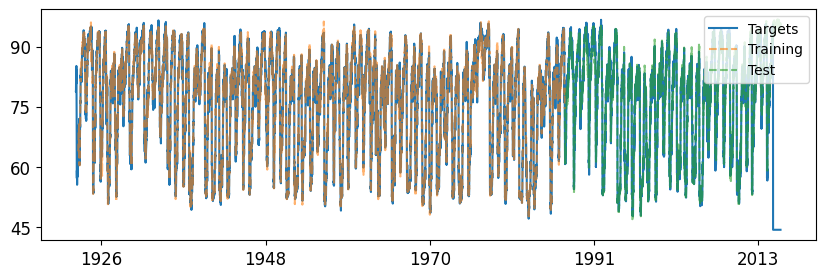

In [ ]:
fig, subax1 = plt.subplots(figsize=(10,3))

subax1.plot(dfouts[location],'-',color='C0',label='Targets')
if interval.lower() != '1d':
    assert interval.lower() == '1h', 'Only supports daily or hourly estimation, but got resolution = %s' % interval
    date_labels = pd.date_range(start=y.index[ndays+nwindows*window_size-1],
                                end=y.index[-1] + pd.Timedelta('23 h'), freq='h')
    subax1.plot(date_labels,
                dfp.loc[:,location_cols].clip(0,dfouts.loc[:,location_cols].max(),axis=1).to_numpy().ravel(order="C"),'--',
                color='C3',alpha=0.6)
else:
    # training sequence
    dfp = yscaler.inverse_transform(pd.DataFrame(np.clip(model.predict(xallc),0,1),yallc.index,columns=yallc.columns))
    subax1.plot(dfp.loc[:,location].clip(0,dfouts.loc[:,location].max(),axis=0),'--',color='C1',alpha=0.6,label='Training')

    # test sequence
    dfp = yscaler.inverse_transform(pd.DataFrame(np.clip(model.predict(xallv),0,1),yallv.index,columns=yallv.columns))
    subax1.plot(dfp.loc[:,location].clip(0,dfouts.loc[:,location].max(),axis=0),'--',color='C2',alpha=0.6,label='Test')

if select_seasons is not None:
    for year in y.index.year.unique():
        if select_seasons =='wet':
            mask = (y.index.year==year) & (y.index.month>=7) & (y.index.month<=12)
        elif select_seasons =='dry':
            mask = (y.index.year==year) & (y.index.month>=1) & (y.index.month<=6)
        subax1.axvspan(y.index[np.argmax(mask)],
                    y.index[len(mask) - np.argmax(mask[::-1]) - 1],
                    facecolor='0.2', alpha=0.3)


plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
subax1.legend(loc='upper right')
# subax1.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
subax1.yaxis.set_major_locator(ticker.MaxNLocator(4))
subax1.xaxis.set_major_locator(ticker.MaxNLocator(6))
subax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


## Save numerical results to Google Drive

In [ ]:
# print(full_results)
import pickle

# create a pickle file on Google Drive and write results
result_path_prefix = "X2_%s_%s%s" % (full_model_str_def, which_70pct+'_chronological'+('' if select_seasons is None else ('_' + select_seasons)),savepath_suffix)
results_path = os.path.join(gdrive_root_path,"results/%s_full_results.pkl" % (result_path_prefix))

f = open(results_path,"wb")
pickle.dump(full_results,f)
f.close()
print('Numerical results saved to %s' % results_path)

# range_results_path = os.path.join(gdrive_root_path,"results/%s_ranged_results.pkl" % (result_path_prefix))

# f = open(range_results_path,"wb")
# pickle.dump(range_results,f)
# f.close()
# print('Ranged numerical results saved to %s' % range_results_path)

Numerical results saved to /content/drive/MyDrive/X2_Estimation/results/X2_i18_d8_d2_o1_first_chronological_full_results.pkl


## Generate Plots

### Exceedance probability plots and time series plots for key stations

In [ ]:
def add_subplot_axes(ax,rect,facecolor='w'): # matplotlib 2.0+
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 54)]              0         
                                                                 
 dense (Dense)               (None, 8)                 440       
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
Randomly selecting 34187 samples for training, 0 for test
1069/1069 [==============================] - 1s 1ms/step
Generating combined exceedance plots...


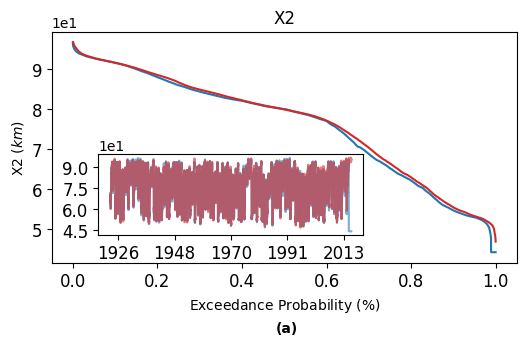

In [ ]:
ncols=1
fig_combined_exceedance, ax_combined_exceedance = plt.subplots(figsize=(6*ncols,3))
# prepare dataset
model_path_prefix = "X2_%s_%s%s" % (full_model_str_def, which_70pct+'_chronological'+('' if select_seasons is None else ('_' + select_seasons)),savepath_suffix)

annmodel = annutils.load_model(os.path.join(gdrive_root_path,'models', model_path_prefix),custom_objects={"mse_loss_masked": mse_loss_masked})
model = annmodel.model

model.summary()
## training results
# dfp=annutils.predict(model, dfinps, xscaler, yscaler,columns=output_stations_w_duplicates_for_time,
#                      ndays=ndays,window_size=window_size,nwindows=nwindows)
if interval =='1h':
    (xallc, yallc), (_, _), xscaler, yscaler = \
    annutils.create_training_sets([dfinps],
                                [dfouts[['%s-%d' % (s, hh) for hh in range(24) for s in output_stations]]],
                                train_frac=1.0,
                                ndays=ndays,window_size=window_size,nwindows=nwindows)
else:
    (xallc, yallc), (_, _), xscaler, yscaler = \
    annutils.create_training_sets([dfinps],
                                [dfouts],
                                train_frac=1.0,
                                ndays=ndays,window_size=window_size,nwindows=nwindows)

dfp = yscaler.inverse_transform(pd.DataFrame(np.clip(model.predict(xallc),0,1),yallc.index,columns=yallc.columns))

print('Generating combined exceedance plots...')
location = 'X2'

if interval.lower() == '1h':
    location_cols = ['%s-%d' % (location, hh) for hh in range(24)]
else:
    location_cols = location
y = dfouts.loc[:,location_cols].copy()
y[y<0] = float('nan')

# Combined exceedance probability plots
if interval.lower() != '1d':
    valid_rows = (dfouts.loc[:,location_cols] > 0).all(axis=1)
    test_y_sorted = np.sort(y[valid_rows].iloc[(ndays+nwindows*window_size-1):].dropna().to_numpy().reshape(-1,1),axis=0)
    test_pred_sorted = np.sort(dfp[valid_rows.loc[dfp.index[0]:dfp.index[-1]]].loc[:,location_cols].clip(0,dfouts.loc[:,location_cols].max(),axis=1).to_numpy().reshape(-1,1),axis=0)
else:
    valid_rows = dfouts.loc[:,location] > 0
    test_y_sorted = np.sort(y[valid_rows].iloc[(ndays+nwindows*window_size-1):].dropna().to_numpy().reshape(-1,1),axis=0)
    test_pred_sorted = np.sort(dfp[valid_rows.loc[dfp.index[0]:dfp.index[-1]]].loc[:,location].clip(0,dfouts.loc[:,location].max()).to_numpy().reshape(-1,1),axis=0)

# calculate the proportional values of samples
p = 1. * np.arange(len(test_y_sorted)-1,-1,-1) / (len(test_y_sorted) - 1)
p_pred = 1. * np.arange(len(test_pred_sorted)-1,-1,-1) / (len(test_pred_sorted) - 1)

# plot the sorted data:
ax_combined_exceedance.plot(p, test_y_sorted,'-',color='C0')
ax_combined_exceedance.plot(p_pred, test_pred_sorted,'-',color='C3')
if ii == ncols:
    ax_combined_exceedance.legend(['Target','Model Predictions'],fontsize=12,bbox_to_anchor=(1.28, 2.76))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax_combined_exceedance.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax_combined_exceedance.set_ylabel('X2 ' + r"$(km)$")
ylims = ax_combined_exceedance.get_ylim()

ax_combined_exceedance.set_xlabel('Exceedance Probability ' + r"$(\%)$")
text_yloc = ylims[0]-(ylims[1]-ylims[0])*0.3

ax_combined_exceedance.text(0.48,
                            text_yloc,
                            '(%s)'%chr(97+ii),weight='bold')
ax_combined_exceedance.set_title(location)

subax1 = add_subplot_axes(ax_combined_exceedance,[0.1,0.12,0.57,0.35]) # xloc, yloc, xwidth, ywidth

subax1.plot(y.iloc[(ndays+nwindows*window_size-1):],'-',color='C0',alpha=0.6)
if interval.lower() != '1d':
    assert interval.lower() == '1h', 'Only supports daily or hourly estimation, but got resolution = %s' % interval
    date_labels = pd.date_range(start=y.index[ndays+nwindows*window_size-1],
                                end=y.index[-1] + pd.Timedelta('23 h'), freq='h')
    subax1.plot(date_labels,
                dfp.loc[:,location_cols].clip(0,dfouts.loc[:,location_cols].max(),axis=1).to_numpy().ravel(order="C"),'--',
                color='C3',alpha=0.6)
else:
    subax1.plot(dfp.loc[:,location].clip(0,dfouts.loc[:,location].max(),axis=0),'-',color='C3',alpha=0.6)
if select_seasons is not None:
    for year in y.index.year.unique():
        if select_seasons =='wet':
            mask = (y.index.year==year) & (y.index.month>=7) & (y.index.month<=12)
        elif select_seasons =='dry':
            mask = (y.index.year==year) & (y.index.month>=1) & (y.index.month<=6)
        subax1.axvspan(y.index[np.argmax(mask)],
                    y.index[len(mask) - np.argmax(mask[::-1]) - 1],
                    facecolor='0.2', alpha=0.3)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
subax1.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
subax1.yaxis.set_major_locator(ticker.MaxNLocator(4))
subax1.xaxis.set_major_locator(ticker.MaxNLocator(6))
subax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


fig_combined_exceedance.savefig(os.path.join(gdrive_root_path,"images/%s_combined_exceedance_prob.png"% model_path_prefix),bbox_inches='tight',dpi=300)

In [ ]:
full_results

{'X2_train': defaultdict(float,
             {'MSE': 0.0007743037415016366,
              'Bias': -0.11715303649062216,
              'R': 0.9933328557298547,
              'RMSD': 0.08379107066762992,
              'NSE': 0.9866691423991784,
              'R^2': 0.9866691416231761}),
 'X2_test': defaultdict(float,
             {'MSE': 0.0008892131942158932,
              'Bias': -0.18081293867196563,
              'R': 0.9923497289044579,
              'RMSD': 0.08419320943167717,
              'NSE': 0.9845178328851965,
              'R^2': 0.9845178321883602})}